# [cknowledge.org/ai](http://cknowledge.org/ai): Crowdsourcing benchmarking and optimisation of AI

A suite of open-source tools for [collecting knowledge on optimising AI](http://bit.ly/hipeac49-ckdl):
* [Android app](https://play.google.com/store/apps/details?id=openscience.crowdsource.video.experiments&hl=en_GB)
* [Desktop app](https://github.com/dividiti/ck-crowdsource-dnn-optimization)
* [CK-Caffe](https://github.com/dividiti/ck-caffe)
* [CK-Caffe2](https://github.com/ctuning/ck-caffe2)
* [CK-TensorFlow](https://github.com/ctuning/ck-tensorflow)
* [CK-TensorRT](https://github.com/dividiti/ck-tensorrt)
* etc.

# [PUBLIC] Benchmarking Caffe with OpenBLAS on Samsung Chromebook 2

## Table of Contents

1. [Overview](#overview)
1. [See the code](#code) [for developers]
1. [Get the data](#data) [for developers]
1. [See the tables](#tables)
  1. [All data](#df_all)
  1. [All execution time data](#df_time)
  1. [Mean execution time per batch](#df_mean_time_per_batch)
  1. [Mean execution time per image](#df_mean_time_per_image)
  1. [Mean number of images per second](#df_mean_images_per_second)
1. [See the graphs](#graphs)
  1. [Mean number of images per second](#graphs)

<a id="overview"></a>
## Overview

We study the **execution time** of inference (forward propagation):
- on the [Samsung Chromebook 2](http://www.samsung.com/us/computer/chrome-os-devices/XE503C12-K01US-specs) **platform**:
  - [CPU] quad-core ARM Cortex-A15 @ 1900 MHz;
  - [CPU] quad-core ARM Cortex-A7 @ 1300 MHz (not used);
  - [GPU] quad-core ARM Mali-T628 @ 600 MHz (not used);
  - [GPU] dual-core ARM Mali-T628 @ 600 MHz (not used);
  - [GPU] OpenCL driver 6.0 (`r6p0-02rel0.b77b627bc37583eeaa34bbee29868088`);
  - [GPU] OpenCL standard 1.1;
  - [RAM] 2 GB;
  - Gentoo Linux [over](community.arm.com/groups/arm-mali-graphics/blog/2014/12/18/installing-opencl-on-chromebook-2-in-30-minutes) ChromeOS:
```
$ cat /etc/lsb-release
CHROMEOS_AUSERVER=https://tools.google.com/service/update2
CHROMEOS_BOARD_APPID={24E2E4F7-F92C-6115-3E26-02C7EAA02946}
CHROMEOS_CANARY_APPID={90F229CE-83E2-4FAF-8479-E368A34938B1}
CHROMEOS_DEVSERVER=
CHROMEOS_RELEASE_APPID={24E2E4F7-F92C-6115-3E26-02C7EAA02946}
CHROMEOS_RELEASE_BOARD=peach_pit-signed-mp-v3keys
CHROMEOS_RELEASE_BRANCH_NUMBER=69
CHROMEOS_RELEASE_BUILDER_PATH=peach_pit-release/R58-9334.69.0
CHROMEOS_RELEASE_BUILD_NUMBER=9334
CHROMEOS_RELEASE_BUILD_TYPE=Official Build
CHROMEOS_RELEASE_CHROME_MILESTONE=58
CHROMEOS_RELEASE_DESCRIPTION=9334.69.0 (Official Build) stable-channel peach_pit 
CHROMEOS_RELEASE_NAME=Chrome OS
CHROMEOS_RELEASE_PATCH_NUMBER=0
CHROMEOS_RELEASE_TRACK=stable-channel
CHROMEOS_RELEASE_VERSION=9334.69.0
DEVICETYPE=CHROMEBOOK
GOOGLE_RELEASE=9334.69.0
$ uname -a
Linux localhost 3.8.11 #1 SMP Wed May 10 18:37:16 PDT 2017 armv7l ARMv7 Processor rev 3 (v7l) SAMSUNG EXYNOS5 (Flattened Device Tree) GNU/Linux
```


- using 3 CNN **models** (net architecture + weights):
  - [AlexNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet);
  - [GoogleNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet);
  - [SqueezeNet 1.1](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1);

- using 1 **library** version:
  - [CPU] [OpenBLAS](https://github.com/xianyi/OpenBLAS) 0.2.19;

- with the **number of threads** varying from 1 to 4;

- with the **batch size** varying from 1 to 4.

<a id="code"></a>
## Data wrangling code

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

### Includes

#### Standard

In [1]:
import os
import sys
import json
import re

#### Scientific

If some of the scientific packages are missing, please install them using:
```
# pip install jupyter pandas numpy matplotlib
```

In [2]:
import IPython as ip
import pandas as pd
import numpy as np
import matplotlib as mp

In [3]:
print ('IPython version: %s' % ip.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('NumPy version: %s' % np.__version__)
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 4.1.1
Pandas version: 0.19.1
NumPy version: 1.11.2
Matplotlib version: 1.5.3


In [4]:
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import display
def display_in_full(df):
    pd.options.display.max_columns = len(df.columns)
    pd.options.display.max_rows = len(df.index)
    display(df)

In [5]:
import matplotlib.pyplot as plt; plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [6]:
default_title = 'Caffe with OpenBLAS on Samsung Chromebook 2'
default_ylabel = 'Execution time (ms)'
default_colormap = cm.autumn
default_fontsize = 16
default_figsize = [16, 16]
default_dpi = 200

In [7]:
if mp.__version__[0]=='2': mp.style.use('classic')
mp.rcParams['figure.figsize'] = default_figsize
mp.rcParams['figure.dpi'] = default_dpi
mp.rcParams['font.size'] = default_fontsize
mp.rcParams['legend.fontsize'] = 'medium'

#### Collective Knowledge

If CK is not installed, please install it using:
```
# pip install ck
```

In [8]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.9.1.1


### Access the experimental data

In [9]:
def get_experimental_results(repo_uoa, tags, time_ms = 'time_fw_ms'):
    module_uoa = 'experiment'
    r = ck.access({'action':'search', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'tags':tags})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    experiments = r['lst']
    
    dfs = []
    for experiment in experiments:
        data_uoa = experiment['data_uoa']
        r = ck.access({'action':'list_points', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'data_uoa':data_uoa})
        if r['return']>0:
            print ("Error: %s" % r['error'])
            exit(1)

        # Get (lib_tag, model_tag) from a list of tags that should be available in r['dict']['tags'].
        # Tags include 2 of the 3 irrelevant tags, a model tag and a lib tag.
        # NB: Since it's easier to list all model tags than all lib tags, the latter list is not expicitly specified.
        tags = r['dict']['tags']
        irrelevant_tags = [ 'explore-batch-size-openblas-threads', 'caffe-time', 'samsung-chromebook2' ]
        model_tags = [ 'bvlc-alexnet', 'bvlc-googlenet', 'deepscale-squeezenet-1.1' ]
        lib_model_tags = [ tag for tag in tags if tag not in irrelevant_tags ]
        model_tags = [ tag for tag in lib_model_tags if tag in model_tags ]
        lib_tags = [ tag for tag in lib_model_tags if tag not in model_tags ]
        if len(lib_tags)==1 and len(model_tags)==1:
            (lib, model) = (lib_tags[0], model_tags[0])
        else:
            continue
        
        for point in r['points']:
            with open(os.path.join(r['path'], 'ckp-%s.0001.json' % point)) as point_file:
                point_data_raw = json.load(point_file)
            characteristics_list = point_data_raw['characteristics_list']
            num_repetitions = len(characteristics_list)            
            # Obtain column data.
            data = [
                {
                    # features
                    'platform' : point_data_raw['features']['platform']['platform']['model'],
                    # choices
                    'lib' : lib,
                    'model' : model,
                    'batch_size' : np.int64(point_data_raw['choices']['env'].get('CK_CAFFE_BATCH_SIZE',-1)),
                    'num_threads' : np.int64(point_data_raw['choices']['env'].get('OPENBLAS_NUM_THREADS',-1)),
                    # statistical repetition
                    'repetition_id': repetition_id,
                    # runtime characteristics
                    'time (ms)'   : characteristics['run'].get(time_ms,+1e9), # "positive infinity"
                    'per layer info' : characteristics['run'].get('per_layer_info',[]),
                    'success?'    : characteristics['run'].get('run_success','n/a')
                }
                for (repetition_id, characteristics) in zip(range(num_repetitions), characteristics_list) 
            ]
            # Deal with missing column data (resulting from failed runs).
            if len(data)==1:
                repetitions = point_data_raw['features'].get('statistical_repetitions',1)
                characteristics = characteristics * repetitions
            # Construct a DataFrame.
            df = pd.DataFrame(data)
            # Set columns and index names.
            df.columns.name = 'run characteristic'
            df.index.name = 'index'
            df = df.set_index([ 'platform', 'lib', 'model', 'num_threads', 'batch_size', 'repetition_id' ])
            # Append to the list of similarly constructed DataFrames.
            dfs.append(df)
    # Concatenate all constructed DataFrames (i.e. stack on top of each other).
    result = pd.concat(dfs)
    return result.sortlevel(result.index.names)

### Plot images per second against the batch size and the number of threads

In [10]:
def plot_trisurf(df_model, x_col, y_col, z_col, x_label=None, y_label=None, z_label=None, title=None):
    x = df_model[x_col]
    y = df_model[y_col]
    z = df_model[z_col]
    
    if x_label == None: x_label = x_col
    if y_label == None: y_label = y_col
    if z_label == None: z_label = z_col
        
    x_ticks = x.unique()
    y_ticks = y.unique()
    
    fig = plt.figure(figsize=(24, 12), dpi=600)
    ax = fig.add_subplot(111, projection='3d')
    trisurf = ax.plot_trisurf(x, y, z, cmap=cm.autumn_r, linewidth=0.2, antialiased=True, shade=True)
    ax.set_xlabel(x_label); ax.set_xticks(x_ticks); ax.set_xlim3d(x_ticks.max(), x_ticks.min())
    ax.set_ylabel(y_label); ax.set_yticks(y_ticks); ax.set_ylim3d(y_ticks.min(), y_ticks.max())
    ax.set_zlabel(z_label); ax.set_zlim3d(z.min(), z.max())
    ax.set_title(title, fontsize=20)
    fig.colorbar(trisurf, shrink=0.5, aspect=10)
    return fig

<a id="data"></a>
## Get the experimental data

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook. 

The Caffe experimental data was collected on the experimental platform (after installing all Caffe libraries and models of interest) as follows:
```
$ cd `ck find ck-caffe:script:explore-batch-size-openblas-threads`
$ python explore-batch-size-openblas-threads-benchmarking.py
```
The data can be downloaded from GitHub via CK as follows:
```
$ ck pull repo:ck-caffe-samsung-chromebook2 --url=https://github.com/dividiti/ck-caffe-samsung-chromebook2
```

<a id="tables"></a>
## Tables

<a id="df_all"></a>
### All data

In [11]:
df_all = get_experimental_results(
    repo_uoa='ck-caffe-samsung-chromebook2',
    tags='explore-batch-size-openblas-threads') \
    .reset_index(['platform', 'lib'], drop=True)
display_in_full(df_all)

run characteristic                                                                                per layer info  \
model                    num_threads batch_size repetition_id                                                      
bvlc-alexnet             1           1          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     2          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     3          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     4          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                         2           1          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     2          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     3          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     4          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                         3           1          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     2          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2              [{u'index': 0, u'direction': u'forward', u'tim...   
                                     3          0              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                1              [{u'index': 0, u'direction': u'forward', u'tim...   
                                                2       

<a id="df_time"></a>
### All execution time data

In [12]:
df_time = df_all['time (ms)'].unstack(df_all.index.names[:-1])
display_in_full(df_time)

model         bvlc-alexnet                                               \
num_threads              1                                   2            
batch_size               1        2        3        4        1        2   
repetition_id                                                             
0                  694.353  1167.06  1674.10  1996.09  524.983  799.439   
1                  696.456  1162.62  1672.91  2005.84  522.722  795.181   
2                  696.375  1156.16  1666.92  2004.88  522.799  796.874   

model                                                                         \
num_threads                            3                                   4   
batch_size           3        4        1        2        3        4        1   
repetition_id                                                                  
0              1121.04  1249.54  475.538  694.085  982.992  1052.49  487.265   
1              1115.98  1255.67  472.089  697.827  960.929  1055.10  477.739   
2              1118.95  1250.69  473.300  695.824  964.487  1052.27  486.216   

model                                    bvlc-googlenet                    \
num_threads                                           1                     
batch_size           2        3        4              1        2        3   
repetition_id                                                               
0              703.497  903.934  966.699        1335.57  2676.17  4020.28   
1              677.439  902.611  965.654        1336.71  2661.66  4000.71   
2              670.514  909.762  963.569        1338.93  2671.69  3985.83   

model                                                                         \
num_threads                   2                                   3            
batch_size           4        1        2        3        4        1        2   
repetition_id                                                                  
0              5297.44  922.396  1794.62  2697.39  3595.34  787.989  1565.81   
1              5315.00  908.155  1798.21  2684.18  3595.20  790.105  1554.96   
2              5320.74  919.381  1797.32  2718.89  3608.52  781.814  1553.64   

model                                                                \
num_threads                            4                              
batch_size           3        4        1        2        3        4   
repetition_id                                                         
0              2317.81  3146.61  718.714  1390.61  2076.34  2835.49   
1              2345.49  3146.14  772.498  1403.51  2112.78  2825.63   
2              2324.12  3094.60  709.756  1391.73  2081.19  2779.02   

model         deepscale-squeezenet-1.1                                      \
num_threads                          1                                   2   
batch_size                           1        2        3        4        1   
repetition_id                                                                
0                              304.267  613.367  917.684  1217.78  197.077   
1                              314.208  614.067  921.206  1216.74  195.849   
2                              316.030  614.589  915.081  1224.21  197.484   

model                                                                         \
num_threads                                     3                              
batch_size           2        3        4        1        2        3        4   
repetition_id                                                                  
0              397.776  594.631  787.323  170.664  341.801  518.305  705.115   
1              396.322  600.282  785.526  170.538  389.126  513.175  682.494   
2              394.886  595.269  788.686  171.891  340.976  511.812  717.512   

model                                              
num_threads          4                             
batch_size           1        2        3        4  
repetition_id                                     

<a id="df_mean_time_per_batch"></a>
### Mean execution time per batch

In [13]:
df_mean_time_per_batch = df_time.describe().ix['mean'].unstack(level='batch_size')
display_in_full(df_mean_time_per_batch)

batch_size                                      1            2            3  \
model                    num_threads                                          
bvlc-alexnet             1             695.728000  1161.946667  1671.310000   
                         2             523.501333   797.164667  1118.656667   
                         3             473.642333   695.912000   969.469333   
                         4             483.740000   683.816667   905.435667   
bvlc-googlenet           1            1337.070000  2669.840000  4002.273333   
                         2             916.644000  1796.716667  2700.153333   
                         3             786.636000  1558.136667  2329.140000   
                         4             733.656000  1395.283333  2090.103333   
deepscale-squeezenet-1.1 1             311.501667   614.007667   917.990333   
                         2             196.803333   396.328000   596.727333   
                         3             171.031000   357.301000   514.430667   
                         4             150.476000   307.291333   461.561000   

batch_size                                      4  
model                    num_threads               
bvlc-alexnet             1            2002.270000  
                         2            1251.966667  
                         3            1053.286667  
                         4             965.307333  
bvlc-googlenet           1            5311.060000  
                         2            3599.686667  
                         3            3129.116667  
                         4            2813.380000  
deepscale-squeezenet-1.1 1            1219.576667  
                         2             787.178333  
                         3             701.707000  
                         4             638.137333

<a id="df_mean_time_per_image"></a>
### Mean execution time per image

In [14]:
batch_sizes = df_mean_time_per_batch.columns.tolist()
df_mean_time_per_image = df_mean_time_per_batch / batch_sizes
display_in_full(df_mean_time_per_image)

batch_size                                      1            2            3  \
model                    num_threads                                          
bvlc-alexnet             1             695.728000   580.973333   557.103333   
                         2             523.501333   398.582333   372.885556   
                         3             473.642333   347.956000   323.156444   
                         4             483.740000   341.908333   301.811889   
bvlc-googlenet           1            1337.070000  1334.920000  1334.091111   
                         2             916.644000   898.358333   900.051111   
                         3             786.636000   779.068333   776.380000   
                         4             733.656000   697.641667   696.701111   
deepscale-squeezenet-1.1 1             311.501667   307.003833   305.996778   
                         2             196.803333   198.164000   198.909111   
                         3             171.031000   178.650500   171.476889   
                         4             150.476000   153.645667   153.853667   

batch_size                                      4  
model                    num_threads               
bvlc-alexnet             1             500.567500  
                         2             312.991667  
                         3             263.321667  
                         4             241.326833  
bvlc-googlenet           1            1327.765000  
                         2             899.921667  
                         3             782.279167  
                         4             703.345000  
deepscale-squeezenet-1.1 1             304.894167  
                         2             196.794583  
                         3             175.426750  
                         4             159.534333

<a id="df_mean_images_per_second"></a>
### Mean images per second

In [15]:
df_mean_seconds_per_image = 1e-3 * df_mean_time_per_image
df_mean_images_per_second = 1 / df_mean_seconds_per_image
display_in_full(df_mean_images_per_second)

batch_size                                   1         2         3         4
model                    num_threads                                        
bvlc-alexnet             1            1.437343  1.721249  1.794999  1.997733
                         2            1.910215  2.508892  2.681788  3.194973
                         3            2.111298  2.873927  3.094476  3.797637
                         4            2.067226  2.924761  3.313322  4.143758
bvlc-googlenet           1            0.747904  0.749109  0.749574  0.753145
                         2            1.090936  1.113142  1.111048  1.111208
                         3            1.271236  1.283584  1.288029  1.278316
                         4            1.363037  1.433401  1.435336  1.421777
deepscale-squeezenet-1.1 1            3.210256  3.257288  3.268008  3.279827
                         2            5.081215  5.046325  5.027422  5.081441
                         3            5.846893  5.597521  5.831690  5.700385
                         4            6.645578  6.508482  6.499683  6.268243

<a id="graphs"></a>
## Graphs

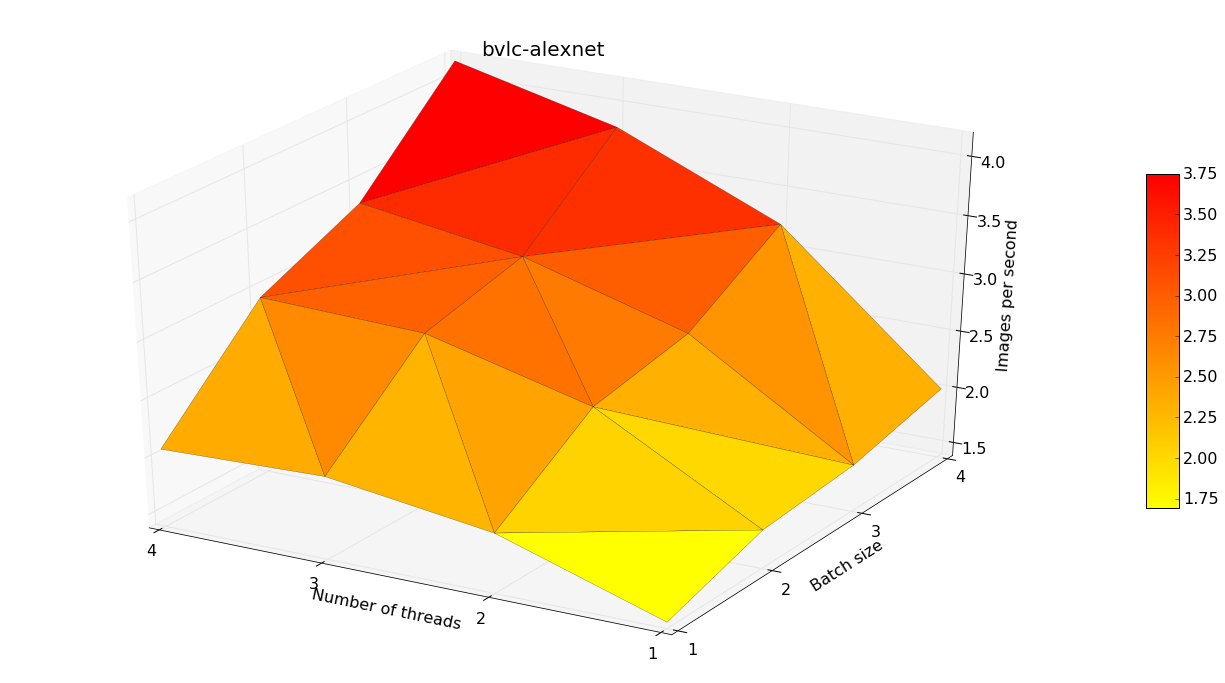

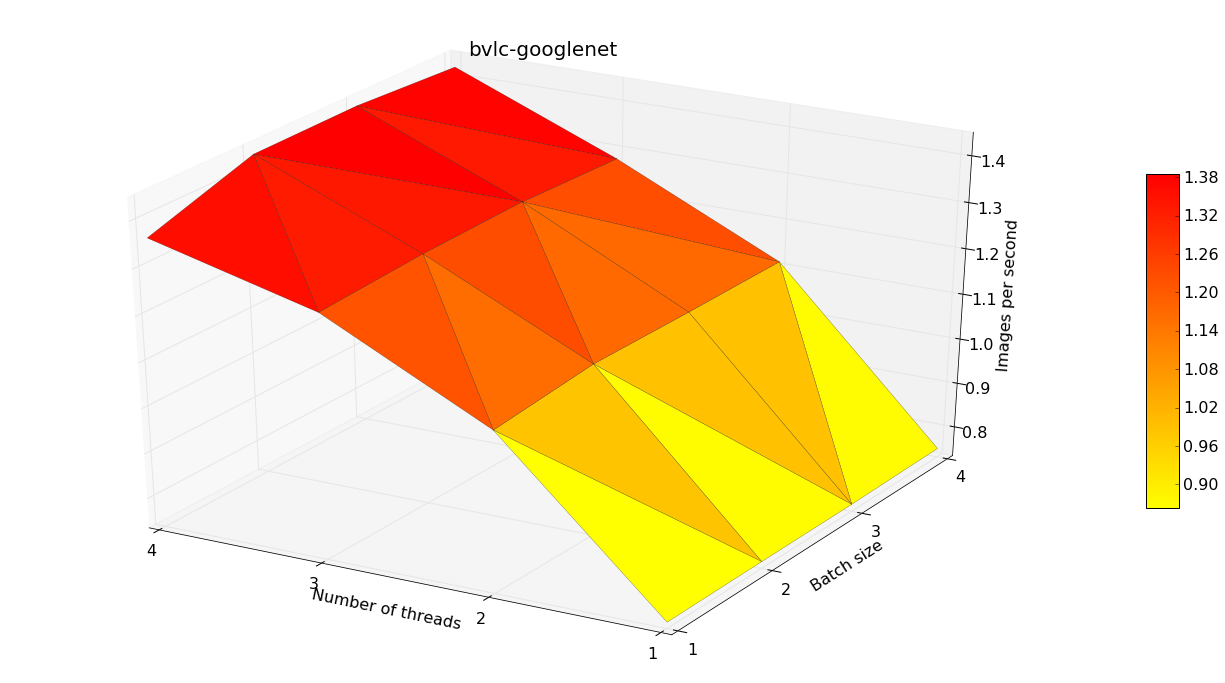

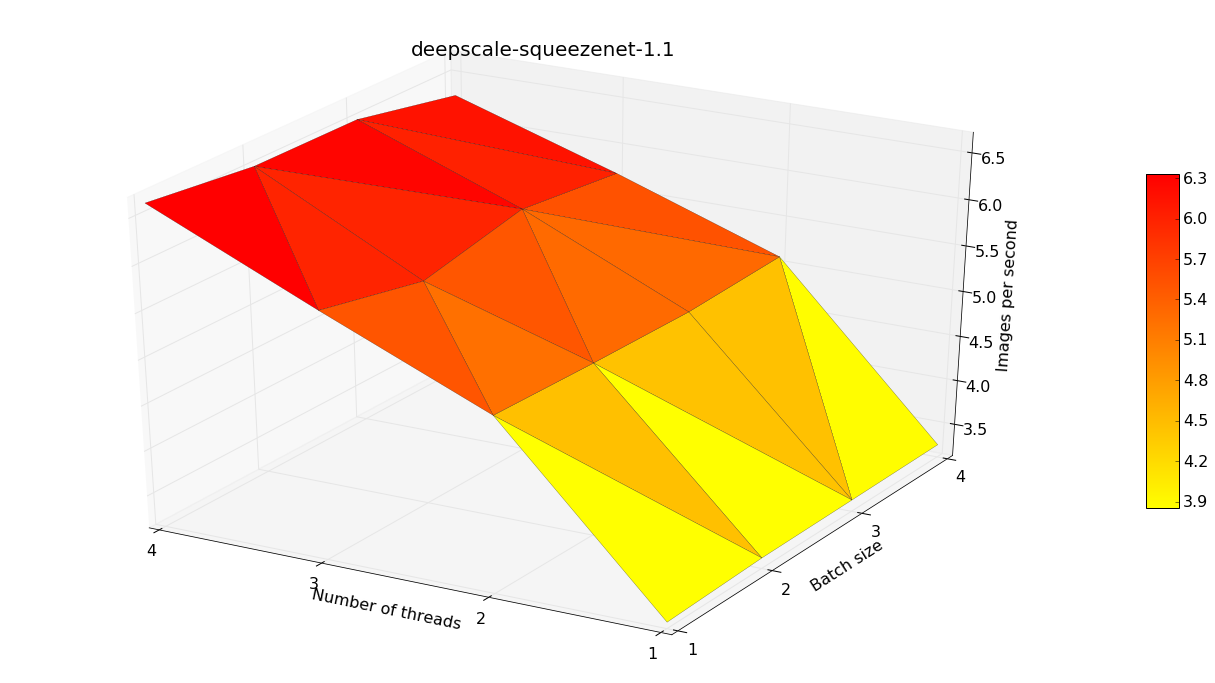

In [17]:
models = df_mean_images_per_second.index.get_level_values('model').unique()
for model in models:
    df_model = df_mean_images_per_second \
        .ix[model] \
        .unstack() \
        .reset_index() \
        .rename(columns={0 : 'time (ms)'}) \
        .dropna() \
        .sort_values(by='batch_size', ascending=False)
    fig = plot_trisurf(df_model, title=model,
                 x_col='num_threads', x_label='Number of threads',
                 y_col='batch_size', y_label='Batch size',
                 z_col='time (ms)', z_label='Images per second')